# importing all the python modules

In [1]:
# general
import os
import glob
import shutil


#dates
from datetime import date
from datetime import time
from datetime import datetime

# data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sb

# biopython
from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord

# phylogenetics
from ete3 import Tree, TreeStyle, NodeStyle, AttrFace, faces, CircleFace
from ete3 import SeqMotifFace, add_face_to_node, TextFace, CircleFace
from ete3 import Nexml

# set display options
pd.options.display.max_columns = 50
os.environ['QT_QPA_PLATFORM']='offscreen'

/home/diana_ir/anaconda3/lib/python3.8/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/diana_ir/anaconda3/lib/python3.8/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [2]:
# definitions
bi_covid_dataset = 'path to file'
concatenated_assembly_metrics = 'path to file'

# wd = '~/buena_vista_study/'
wd = 'path to file'
os.chdir(wd)
os.getcwd()

'/home/diana_ir/Documents/adams_bv_project/adams_county/acdc_20220414'

In [3]:
# import the post_assembled_genomes.py script
os.chdir('path to file')
import indel_finder as indel_finder

# import the nextclade parser function
import nextclade_json_parser as parser

# import clean horizon query script
# import clean_horizon_cov_pui_query as clean_query
import clean_horizon_covpui_varseq_fix_collection_date_2 as clean_query 

os.chdir(wd)

# 1. merging pui and varseq

In [4]:
# 1 = merging  bicovid and varseq
bicovid_path = 'path to file'
varseq_path = 'path to file'

bicovid_varseq = clean_query.main(bicovid_path =  bicovid_path, varseq_path = varseq_path)
bicovid_varseq = bicovid_varseq.reset_index(drop = True)
bicovid_varseq.head()

# save files
outfile = os.path.join(wd, '01_bicovid_varseq.csv')
bicovid_varseq.to_csv(outfile, index = False)


  .... merging bicovid and CV_VAR_SEQ dataset queries

  .... cleaning filtered merged dataset query
  .... there are 227146 lines of data in query
  ....fixing date formats
  ....cleaning up patient and customer names
....finished cleaning query


# 2. fix collection dates from pui and cv_var

In [5]:
# to fix collection dates from  bi_covid and cv_var
path = os.path.join(wd, '01_bicovid_varseq.csv')
query = pd.read_csv(path, dtype = {"accession_id" : object})

# drop test clients
crit = query.cust_name != 'Test Client- For Testing only'
query = query[crit]
query = query.reset_index(drop = True)

# replace missing collection_dates with receive dates
crit = query.collection_date.isna()
print('number of NAs collection dates: %d' % query[crit].shape[0])
query.collection_date = query.collection_date.fillna('')
print(crit.shape)

# how many collection dates need to be corrected
crit = query.collection_date < '2020-03-01'
print('will we replace %d collection dates (before 2020-03-01) with receive dates' % query[crit].shape[0])
print('')
print(crit.shape)



collection_date_mod_list = []

for row in range(query.shape[0]):
    
    collection_date = query.collection_date[row]
    receive_date = query.receive_date[row]
#     print(collection_date, receive_date, query.cust_name[row], query.first_name[row])
    
    if collection_date < '2020-03-01' or collection_date == '':
        collection_date_mod_list.append(receive_date)
    else:
        collection_date_mod_list.append(collection_date)
        
query['collection_date_mod'] = collection_date_mod_list
query.head()


outfile = os.path.join(wd, '02_collection_date_mod.csv')
query.to_csv(outfile, index = False)

number of NAs collection dates: 114
(227137,)
will we replace 148 collection dates (before 2020-03-01) with receive dates

(227137,)


In [7]:
path = os.path.join (wd, "02_collection_date_mod.csv")
df = pd.read_csv (path, dtype = {'accession_id' : object})

def addprefix (accession_id):
    return 'CO-CDPHE-%s' % accession_id

fasta_header = df.apply(lambda x: addprefix (x.accession_id), axis =1)
df.insert(value = fasta_header, column = 'fasta_header', loc =0)
df.dtypes

# make identifier
# to get the number of individuals
def make_identifier(last_name, first_name, dob):
    return "%s_%s_%s" % (last_name, first_name, dob)

df.first_name = df.first_name.str.capitalize()
df.first_name = df.first_name.str.strip()
df.last_name = df.last_name.str.capitalize()
df.last_name = df.last_name.str.strip()
df.dob= pd.to_datetime(df.dob).dt.date

# df.last_name= df.last_name.str.capitalize()



identifier = df.apply(lambda x:make_identifier(x.last_name, x.first_name, x.dob), axis = 1)
df.insert(value = identifier, column = "person_id", loc = 0)

print(df.shape)

# save
outfile = os.path.join(wd, '02_collection_date_mod.csv')
df.to_csv(outfile, index = False)
df


(227137, 12)


,person_id,fasta_header,accession_id,collection_date,cust_name,first_name,last_name,dob,zip,county,receive_date,collection_date_mod
0,Willis_Jonathan_1996-11-16,CO-CDPHE-2101445435,2101445435,NaN,"University of Colorado Hospital, Clinical",Jonathan,Willis,1996-11-16,NaN,NaN,2021-07-19,2021-07-19
1,Tabb_Eugene_1952-01-11,CO-CDPHE-2101445427,2101445427,NaN,"University of Colorado Hospital, Clinical",Eugene,Tabb,1952-01-11,NaN,NaN,2021-07-19,2021-07-19
2,Ulibarri_Evrick_1960-12-20,CO-CDPHE-2101577540,2101577540,NaN,Sky Ridge Medical Center,Evrick,Ulibarri,1960-12-20,NaN,NaN,2021-08-17,2021-08-17
3,Stanton_Taylor_1989-12-24,CO-CDPHE-2008022578,2008022578,1920-07-31,Colorado National Guard,Taylor,Stanton,1989-12-24,80634,Weld,2020-08-02,2020-08-02
4,Vasquez_Anthony lee_1950-02-23,CO-CDPHE-2101271526,2101271526,1950-02-23,Denver Health Medical Center,Anthony lee,Vasquez,1950-02-23,80223,NaN,2021-06-09,2021-06-09
...,...,...,...,...,...,...,...,...,...,...,...,...
227132,Cappellucci_Jessica_1993-12-12,CO-CDPHE-2101791178,2101791178,2021-09-20,CMHI Pueblo COVID-19 CTC (Staff),Jessica,Cappellucci,1993-12-12,81007,Pueblo,2021-09-20,2021-09-20
227133,Fish_Steve_1961-01-08,CO-CDPHE-2101791092,2101791092,2021-09-20,Tender Care Assisted Living - Wheat Ridge,Steve,Fish,1961-01-08,80226,NaN,2021-09-20,2021-09-20
227134,Alderson_Marie_1932-04-24,CO-CDPHE-2101790574,2101790574,2021-09-20,Brookdale Meridian Westland,Marie,Alderson,1932-04-24,80215,Jefferson,2021-09-20,2021-09-20
227135,Bathurst_Samantha_1994-06-09,CO-CDPHE-2101790193,2101790193,2021-09-20,The Center at Lowry,Samantha,Bathurst,1994-06-09,80230,NaN,2021-09-20,2021-09-20


In [8]:
# adding the "blank" staff members into the dataset
path = os.path.join (wd, 'path to file')
filename = pd.read_csv (path, dtype = {'accession_id' : object})


filename.head()
filename.collection_date = pd.to_datetime(filename.collection_date, format = '%m/%d/%Y')
filename = filename.rename(columns = {'collection_date' : 'collection_date_mod'})
filename = filename.accession_id.unique().tolist()

print(len(df.accession_id.unique().tolist())) # number of indivduals taht have tested positive 


227137


In [9]:
# filtering dataset to filename
path = os.path.join (wd, "02_collection_date_mod.csv")
df = pd.read_csv (path, dtype = {'accession_id' : object})

crit = df.cust_name == 'filter file'
crit2 = df.accession_id.isin(filename)
filename_filtered = df[crit | crit2]
print(filename_filtered.shape)

# save
outfile = os.path.join(wd, '03_filename_filtered.csv')
filename_filtered.to_csv(outfile, index = False)
filename_filtered

(2645, 12)


,person_id,fasta_header,accession_id,collection_date,cust_name,first_name,last_name,dob,zip,county,receive_date,collection_date_mod
7,Ashburn_Michael_1983-03-11,CO-CDPHE-2005310630,2005310630,1983-03-11,Adams County Detention Facility,Michael,Ashburn,1983-03-11,80601,Adams,2020-05-31,2020-05-31
416,Mendez_Gerardo_1984-07-07,CO-CDPHE-2005140309,2005140309,2020-05-14,Adams County Detention Facility,Gerardo,Mendez,1984-07-07,80601,Adams,2020-05-14,2020-05-14
651,Ashburn_Michael_1983-03-11,CO-CDPHE-2005210959,2005210959,2020-05-21,Adams County Detention Facility,Michael,Ashburn,1983-03-11,80601,Adams,2020-05-21,2020-05-21
1418,Ashburn_Michael_1983-03-11,CO-CDPHE-2006120310,2006120310,2020-06-09,Adams County Detention Facility,Michael,Ashburn,1983-03-11,80601,NaN,2020-06-12,2020-06-09
1575,Arciniega_Sonia_1973-03-05,CO-CDPHE-2006150505,2006150505,2020-06-15,Adams County Detention Facility,Sonia,Arciniega,1973-03-05,80601,Adams,2020-06-15,2020-06-15
...,...,...,...,...,...,...,...,...,...,...,...,...
226879,White_Ashley_1995-02-22,CO-CDPHE-2101044523,2101044523,2021-05-07,Adams County Detention Facility,Ashley,White,1995-02-22,80601,NaN,2021-05-09,2021-05-07
226880,Makinster_April_1984-01-04,CO-CDPHE-2101044472,2101044472,2021-05-07,Adams County Detention Facility,April,Makinster,1984-01-04,80601,NaN,2021-05-09,2021-05-07
226881,Espinoza_Timothy_1978-07-02,CO-CDPHE-2101044473,2101044473,2021-05-08,Adams County Detention Facility,Timothy,Espinoza,1978-07-02,80601,NaN,2021-05-09,2021-05-08
226916,Morua-lara_Oscar_2002-06-30,CO-CDPHE-2101157989,2101157989,2021-05-21,Adams County Detention Facility,Oscar,Morua-lara,2002-06-30,80601,NaN,2021-05-22,2021-05-21


In [10]:
# dropping duplicates in filename filtered samples
path = os.path.join (wd, "03_filename_filtered.csv")
df = pd.read_csv (path, dtype = {'accession_id' : object})

filename_dropdups = df.drop_duplicates(subset = 'person_id', keep = 'first')
print(filename_dropdups.shape)

# save
outfile = os.path.join(wd, '04_filename_dropped_duplicates.csv')
filename_dropdups.to_csv(outfile, index = False)
filename_dropdups

(1508, 12)


,person_id,fasta_header,accession_id,collection_date,cust_name,first_name,last_name,dob,zip,county,receive_date,collection_date_mod
0,Ashburn_Michael_1983-03-11,CO-CDPHE-2005310630,2005310630,1983-03-11,Adams County Detention Facility,Michael,Ashburn,1983-03-11,80601.0,Adams,2020-05-31,2020-05-31
1,Mendez_Gerardo_1984-07-07,CO-CDPHE-2005140309,2005140309,2020-05-14,Adams County Detention Facility,Gerardo,Mendez,1984-07-07,80601.0,Adams,2020-05-14,2020-05-14
4,Arciniega_Sonia_1973-03-05,CO-CDPHE-2006150505,2006150505,2020-06-15,Adams County Detention Facility,Sonia,Arciniega,1973-03-05,80601.0,Adams,2020-06-15,2020-06-15
5,Christmas_Steven_1959-05-02,CO-CDPHE-2006170703,2006170703,2020-06-15,Adams County Detention Facility,Steven,Christmas,1959-05-02,80601.0,Adams,2020-06-17,2020-06-15
6,Walker_Mickey_1978-12-04,CO-CDPHE-2006170010,2006170010,2020-06-16,Adams County Detention Facility,Mickey,Walker,1978-12-04,80601.0,Adams,2020-06-17,2020-06-16
...,...,...,...,...,...,...,...,...,...,...,...,...
2633,Parker_Eugene_1982-08-27,CO-CDPHE-2101033817,2101033817,2021-05-05,Adams County Detention Facility,Eugene,Parker,1982-08-27,80601.0,NaN,2021-05-07,2021-05-05
2636,Ibouanga-tombet_Gedeon_2000-04-11,CO-CDPHE-2101033555,2101033555,2021-05-06,Adams County Detention Facility,Gedeon,Ibouanga-tombet,2000-04-11,80601.0,NaN,2021-05-07,2021-05-06
2637,Akers_Michael_1992-01-20,CO-CDPHE-2101033569,2101033569,2021-05-06,Adams County Detention Facility,Michael,Akers,1992-01-20,80601.0,NaN,2021-05-07,2021-05-06
2643,Morua-lara_Oscar_2002-06-30,CO-CDPHE-2101157989,2101157989,2021-05-21,Adams County Detention Facility,Oscar,Morua-lara,2002-06-30,80601.0,NaN,2021-05-22,2021-05-21


In [12]:
# ensuring that person_id is only mentioned once
path = os.path.join (wd, "04_filename_dropped_duplicates.csv")
filename_person_id = pd.read_csv (path, dtype = {'accession_id' : object})


# making sure that person_id are only mentioned once
filename_person_id = filename_person_id.reset_index(drop=True)
for row in range (filename_person_id.shape[0]) : 
    person_id = filename_person_id.person_id[row]
    if person_id in corrections_dictionary.keys() : 
        print(person_id)
        filename_person_id.at[row, 'person_id'] = corrections_dictionary [person_id]
print(filename_person_id.shape)

filename_person_id = filename_person_id.drop_duplicates(subset = 'person_id', keep = 'first')
print(filename_person_id.shape)
        
# save
outfile = os.path.join(wd, '04_filename_person_id.csv')
filename_person_id.to_csv(outfile, index = False)
filename_person_id

Pruitt_Chantel_1996-06-14
Tallmich_Joseph_1977-08-09
Leon_Matthew_1994-01-12
Surls,_Timothy_1993-09-15
Duenas_Alberto_1984-07-08
Carillo-meija_Byron_1980-02-07
Villgas-avila_Pedro_1982-07-05
Pena-quinones_Ricardo_1996-04-03
Jensen-gurule_Luke ryan_1986-12-24
Dedios-tlmanalco_Herminio_1980-07-10
Carranza-chavez_Gonzaol_1971-09-11
Dedios-tlalmanalco_Herminio_1980-07-10
Lo_Ricky_1989-03-03
Courtaway_Aaron z_1995-11-01
Cotney_Bryon_1982-10-16
Anderson_Derric_1974-05-15
(1508, 12)
(1495, 12)


,person_id,fasta_header,accession_id,collection_date,cust_name,first_name,last_name,dob,zip,county,receive_date,collection_date_mod
0,Ashburn_Michael_1983-03-11,CO-CDPHE-2005310630,2005310630,1983-03-11,Adams County Detention Facility,Michael,Ashburn,1983-03-11,80601.0,Adams,2020-05-31,2020-05-31
1,Mendez_Gerardo_1984-07-07,CO-CDPHE-2005140309,2005140309,2020-05-14,Adams County Detention Facility,Gerardo,Mendez,1984-07-07,80601.0,Adams,2020-05-14,2020-05-14
2,Arciniega_Sonia_1973-03-05,CO-CDPHE-2006150505,2006150505,2020-06-15,Adams County Detention Facility,Sonia,Arciniega,1973-03-05,80601.0,Adams,2020-06-15,2020-06-15
3,Christmas_Steven_1959-05-02,CO-CDPHE-2006170703,2006170703,2020-06-15,Adams County Detention Facility,Steven,Christmas,1959-05-02,80601.0,Adams,2020-06-17,2020-06-15
4,Walker_Mickey_1978-12-04,CO-CDPHE-2006170010,2006170010,2020-06-16,Adams County Detention Facility,Mickey,Walker,1978-12-04,80601.0,Adams,2020-06-17,2020-06-16
...,...,...,...,...,...,...,...,...,...,...,...,...
1503,Parker_Eugene_1982-08-27,CO-CDPHE-2101033817,2101033817,2021-05-05,Adams County Detention Facility,Eugene,Parker,1982-08-27,80601.0,NaN,2021-05-07,2021-05-05
1504,Ibouanga-tombet_Gedeon_2000-04-11,CO-CDPHE-2101033555,2101033555,2021-05-06,Adams County Detention Facility,Gedeon,Ibouanga-tombet,2000-04-11,80601.0,NaN,2021-05-07,2021-05-06
1505,Akers_Michael_1992-01-20,CO-CDPHE-2101033569,2101033569,2021-05-06,Adams County Detention Facility,Michael,Akers,1992-01-20,80601.0,NaN,2021-05-07,2021-05-06
1506,Morua-lara_Oscar_2002-06-30,CO-CDPHE-2101157989,2101157989,2021-05-21,Adams County Detention Facility,Oscar,Morua-lara,2002-06-30,80601.0,NaN,2021-05-22,2021-05-21


In [14]:
# open up the file
path = '/home/diana_ir/Documents/nextstrain/covid_sequencing/concat_metrics/concatenated_assembly_metrics_2022-04-14.csv'
seq_metrics = pd.read_csv (path, dtype = {'accession_id' : object})

drop_col = ['fasta_header']

seq_metrics = seq_metrics.drop(columns= drop_col)

path = os.path.join (wd, '04_filename_person_id.csv')
filename_person_id = pd.read_csv (path, dtype = {'accession_id' : object})

# merging pui & varseq with seq data
seq_metrics = seq_metrics.sort_values(by = 'percent_non_ambigous_bases', ascending = False)
seq_metrics = seq_metrics.drop_duplicates(subset = 'accession_id', keep = 'first')
seq_metrics = seq_metrics.set_index('accession_id')
filename_person_id = filename_person_id.set_index('accession_id')

# joining concatenated assembly metrics with filtered data
j = filename_person_id.join(seq_metrics, how = 'left')
j = j.reset_index() #don't put drop because we don't want to drop accession id
print(j.shape)

# save
outfile = os.path.join(wd, '05_seq_metrics_filename_person_id.csv')
j.to_csv(outfile, index = False)

(1495, 62)


In [15]:
# open up the file
path = os.path.join (wd, '05_seq_metrics_filename_person_id.csv')
seq_metrics_filename_person_id = pd.read_csv (path, dtype = {'accession_id' : object})

# drop NA in percent non ambiguous bases, unique to individuals
na = seq_metrics_filename_person_id.dropna(axis=0, subset = ['percent_non_ambigous_bases'])
print(na.shape)

# drop duplicates
na = na.drop_duplicates(subset = 'person_id', keep = 'first')
print(na.shape)
na

# save
outfile = os.path.join(wd, '06_droppedna_percent_non_ambiguous_bases.csv')
na.to_csv(outfile, index = False)

(889, 62)
(889, 62)


In [16]:
# read in files
path = os.path.join (wd, '06_droppedna_percent_non_ambiguous_bases.csv')
na = pd.read_csv (path, dtype = {'accession_id' : object})

# has >90% coverage
na = na.sort_values(by = 'percent_non_ambigous_bases', ascending = False)
print(na.shape)

crit = na.percent_non_ambigous_bases >= 90
cov = na[crit]
print(cov.shape)

crit2 = na.percent_non_ambigous_bases <=90
crit3 = na.percent_non_ambigous_bases >1
nocov = na[crit2 & crit3]
print(nocov.shape)

crit4 = na.percent_non_ambigous_bases == 0
zero = na[crit4]
print(zero.shape)

# save
outfile = os.path.join(wd, '07_high_coverage_samples.csv')
cov.to_csv(outfile, index = False)

outfile = os.path.join(wd, '08_low_coverage_samples.csv')
nocov.to_csv(outfile, index = False)

outfile = os.path.join(wd, '08_zero_coverage_samples.csv')
zero.to_csv(outfile, index = False)

(889, 62)
(551, 62)
(295, 62)
(33, 62)


In [17]:
# calls lineages >90% high coverage samples, remove duplications
path = os.path.join (wd, '07_high_coverage_samples.csv')
high = pd.read_csv (path, dtype = {'accession_id' : object})

# drop duplicates
high = high.sort_values(by = 'collection_date')
high = high.drop_duplicates(subset = 'person_id', keep = 'first')
print(high.shape)
high

# save
outfile = os.path.join(wd, '09_high_cov_drop_dups.csv')
high.to_csv(outfile, index = False)

(551, 62)


In [18]:
# acquire leftover samples that didn't link to TriCounty Epi data
path = os.path.join (wd, '08_low_coverage_samples.csv')
low = pd.read_csv (path, dtype = {'accession_id' : object})

# drop duplicates
low = low.sort_values(by = 'collection_date')
low = low.drop_duplicates(subset = 'person_id', keep = 'first')
print(low.shape)
low

# save
outfile = os.path.join(wd, '10_low_cov_drop_dups.csv')
low.to_csv(outfile, index = False)

(295, 62)


# high coverage --> assembly metrics and fasta

In [19]:
# open data up
path = os.path.join (wd, '09_high_cov_drop_dups.csv')
high = pd.read_csv (path, dtype = {'accession_id' : object})

# merging with lineage
outfile = '09_highcov_assembly_metrics.csv'
high.to_csv(outfile, index = False)
high

# using filtered assembly metrics we want to pull to out the fasta files for those sequences
out_fasta = '09_highcov_sequences.fasta'
if os.path.isfile(out_fasta):
    os.remove(out_fasta)

n=0
for row in range(high.shape[0]):
    n=n+1
    accession_id = high.accession_id[row]
    seq_run = high.seq_run[row]
    
    fasta_file_path = '/home/diana_ir/Documents/nextstrain/covid_sequencing/fasta_files/%s/%s_consensus_renamed.fa' % (seq_run, accession_id)
    
    print(n, 'adding %s_consensus_renamed.fa from %s to concatenated fasta file' % (accession_id, seq_run))
    record = SeqIO.read(fasta_file_path, 'fasta')
    with open(out_fasta, 'a') as out_handle:
        SeqIO.write(record, out_handle, 'fasta')
        
# on terminal, run pangolin on these files


1 adding 2007080816_consensus_renamed.fa from NEXSEQ_013 to concatenated fasta file
2 adding 2007222738_consensus_renamed.fa from NEXSEQ_017 to concatenated fasta file
3 adding 2008022287_consensus_renamed.fa from NEXSEQ_019 to concatenated fasta file
4 adding 2008161334_consensus_renamed.fa from COVSEQ_0012a to concatenated fasta file
5 adding 2008232080_consensus_renamed.fa from NEXSEQ_021 to concatenated fasta file
6 adding 2008241693_consensus_renamed.fa from COVMIN_0028rr to concatenated fasta file
7 adding 2009262446_consensus_renamed.fa from COVMIN_0022 to concatenated fasta file
8 adding 2010140631_consensus_renamed.fa from COVMIN_0090 to concatenated fasta file
9 adding 2100117854_consensus_renamed.fa from COVMIN_0096 to concatenated fasta file
10 adding 2011025370_consensus_renamed.fa from COVMIN_0090 to concatenated fasta file
11 adding 2011055589_consensus_renamed.fa from COVMIN_0090 to concatenated fasta file
12 adding 2011055811_consensus_renamed.fa from COVMIN_0090 to co

125 adding 2100111868_consensus_renamed.fa from COVMIN_0096 to concatenated fasta file
126 adding 2100111732_consensus_renamed.fa from COVMIN_0096 to concatenated fasta file
127 adding 2100111878_consensus_renamed.fa from COVMIN_0096 to concatenated fasta file
128 adding 2100111920_consensus_renamed.fa from COVMIN_0096 to concatenated fasta file
129 adding 2100111731_consensus_renamed.fa from COVMIN_0096 to concatenated fasta file
130 adding 2100117713_consensus_renamed.fa from COVMIN_0096 to concatenated fasta file
131 adding 2100117717_consensus_renamed.fa from COVMIN_0096 to concatenated fasta file
132 adding 2100117792_consensus_renamed.fa from COVMIN_0096 to concatenated fasta file
133 adding 2100117787_consensus_renamed.fa from COVMIN_0096 to concatenated fasta file
134 adding 2100117776_consensus_renamed.fa from COVMIN_0097 to concatenated fasta file
135 adding 2100117700_consensus_renamed.fa from COVMIN_0096 to concatenated fasta file
136 adding 2100117678_consensus_renamed.fa 

239 adding 2100392971_consensus_renamed.fa from COVMIN_0021 to concatenated fasta file
240 adding 2100431711_consensus_renamed.fa from COVMIN_0022 to concatenated fasta file
241 adding 2100449745_consensus_renamed.fa from COVSEQ_0053 to concatenated fasta file
242 adding 2100449830_consensus_renamed.fa from COVSEQ_0053 to concatenated fasta file
243 adding 2100449750_consensus_renamed.fa from COVSEQ_0053 to concatenated fasta file
244 adding 2100449820_consensus_renamed.fa from COVSEQ_0053 to concatenated fasta file
245 adding 2100449768_consensus_renamed.fa from COVSEQ_0053 to concatenated fasta file
246 adding 2100449808_consensus_renamed.fa from COVSEQ_0053 to concatenated fasta file
247 adding 2100449839_consensus_renamed.fa from COVSEQ_0053 to concatenated fasta file
248 adding 2100492378_consensus_renamed.fa from COVMIN_0011 to concatenated fasta file
249 adding 2100492372_consensus_renamed.fa from COVMIN_0011 to concatenated fasta file
250 adding 2100492457_consensus_renamed.fa 

339 adding 2101940228_consensus_renamed.fa from COVMIN_0324 to concatenated fasta file
340 adding 2101940176_consensus_renamed.fa from COVMIN_0324 to concatenated fasta file
341 adding 2101940105_consensus_renamed.fa from COVMIN_0324 to concatenated fasta file
342 adding 2101939840_consensus_renamed.fa from COVMIN_0324 to concatenated fasta file
343 adding 2101940163_consensus_renamed.fa from COVMIN_0324 to concatenated fasta file
344 adding 2101940029_consensus_renamed.fa from COVMIN_0324 to concatenated fasta file
345 adding 2101939987_consensus_renamed.fa from COVMIN_0324 to concatenated fasta file
346 adding 2101939990_consensus_renamed.fa from COVMIN_0324 to concatenated fasta file
347 adding 2101939920_consensus_renamed.fa from COVMIN_0324 to concatenated fasta file
348 adding 2101940188_consensus_renamed.fa from COVMIN_0324 to concatenated fasta file
349 adding 2101939973_consensus_renamed.fa from COVMIN_0324 to concatenated fasta file
350 adding 2101936068_consensus_renamed.fa 

441 adding 2102157987_consensus_renamed.fa from NEXSEQ_093 to concatenated fasta file
442 adding 2102158018_consensus_renamed.fa from NEXSEQ_079 to concatenated fasta file
443 adding 2102165843_consensus_renamed.fa from NEXSEQ_079 to concatenated fasta file
444 adding 2102165827_consensus_renamed.fa from NEXSEQ_093 to concatenated fasta file
445 adding 2102162213_consensus_renamed.fa from NEXSEQ_079 to concatenated fasta file
446 adding 2102159244_consensus_renamed.fa from NEXSEQ_079 to concatenated fasta file
447 adding 2102159235_consensus_renamed.fa from NEXSEQ_079 to concatenated fasta file
448 adding 2102191788_consensus_renamed.fa from NEXSEQ_079 to concatenated fasta file
449 adding 2102187275_consensus_renamed.fa from NEXSEQ_079 to concatenated fasta file
450 adding 2102187513_consensus_renamed.fa from NEXSEQ_079 to concatenated fasta file
451 adding 2102188420_consensus_renamed.fa from NEXSEQ_079 to concatenated fasta file
452 adding 2102191692_consensus_renamed.fa from NEXSEQ

In [20]:
# read file in
path = os.path.join (wd, '09_highcov_assembly_metrics.csv')
high = pd.read_csv(path, dtype = {'accession_id' : object})
print(high.shape)

# join lineage report with assembly metrics
path = os.path.join (wd, '09_highcov_lineage_report.csv')
pangolin = pd.read_csv(path, dtype = {'taxon': object})
print(pangolin.shape)

drop_col = ['pangolin_version']
high = high.drop(columns=drop_col)

# merge file together
highcov_metrics_lineage = high.join(pangolin, how = 'left')
highcov_metrics_lineage = highcov_metrics_lineage.reset_index()
print(highcov_metrics_lineage.shape)

# save file
outfile = '11_highcov_metrics_pangolin.csv'
highcov_metrics_lineage.to_csv(outfile, index= False)
highcov_metrics_lineage.shape

(551, 62)
(551, 16)
(551, 78)


(551, 78)

# low coverage --> assembly metrics and fasta

In [21]:
# open data up
path = os.path.join (wd, '10_low_cov_drop_dups.csv')
low = pd.read_csv (path, dtype = {'accession_id' : object})

low['lineage'] = 'low quality sequences'

# save file
outfile = '12_lowcov_metrics_lqseq.csv'
low.to_csv(outfile, index= False)
low.shape


(295, 63)

# combining high and low coverage metrics pangolin data

In [22]:
# read files
path = os.path.join (wd, '12_lowcov_metrics_lqseq.csv')
low = pd.read_csv(path, dtype = {'accession_id' : object})
print(low.shape)

path = os.path.join (wd, '11_highcov_metrics_pangolin.csv')
high = pd.read_csv(path, dtype = {'accession_id' : object})
print(high.shape)


# concatenate files together
comb = pd.concat([high, low])
comb.reset_index()
print(comb.shape)

# save file
outfile = '13_combined_metrics_pangolin.csv'
comb.to_csv(outfile, index= False)

(295, 63)
(551, 78)
(846, 78)


# read in 'no sequences' dataset

In [23]:
# read files
path = os.path.join (wd, '05_seq_metrics_filename_person_id.csv')
na = pd.read_csv(path, dtype = {'person_id' : object})
na = na.sort_values (by = 'person_id')
print(na.shape)

# creating a crit that drops high / low coverage
crit = na['percent_non_ambigous_bases'].isnull()
noseq = na[crit]
print(noseq.shape)

# drop duplicates
noseq = noseq.sort_values(by = 'collection_date')
noseq = noseq.drop_duplicates(subset = 'person_id', keep = 'first')
print(noseq.shape)

# save file
outfile = '14_no_sequences.csv'
noseq.to_csv(outfile, index= False)

(1495, 62)
(606, 62)
(606, 62)


In [24]:
# read files
path = os.path.join (wd, '14_no_sequences.csv')
noseq = pd.read_csv(path, dtype = {'person_id' : object})
noseq = noseq.sort_values (by = 'person_id')
print(noseq.shape)

noseq['lineage'] = 'not sequenced'

# save file
outfile = '15_no_sequences_labeled.csv'
noseq.to_csv(outfile, index= False)

(606, 62)


# combining high/low seq with noseq datasets

In [27]:
# read files
path = os.path.join (wd, '13_combined_metrics_pangolin.csv')
comb = pd.read_csv(path, dtype = {'accession_id' : object})
print(comb.shape)

path = os.path.join (wd, '15_no_sequences_labeled.csv')
noseq = pd.read_csv(path, dtype = {'accession_id' : object})
print(noseq.shape)

# concatenate files together
comb_noseq = pd.concat([comb, noseq])
comb_noseq.reset_index()
print(comb_noseq.shape)

# save file
outfile = '16_final_version.csv'
comb_noseq.to_csv(outfile, index= False)

(846, 78)
(606, 63)
(1452, 78)


In [33]:
# read files
path = os.path.join (wd, '16_final_version.csv')
final = pd.read_csv(path, sep = '\t', dtype = {'accession_id' : object})
print(final.shape)

# aggreate by date
final.collection_date_mod = pd.to_datetime(final['collection_date_mod']) - pd.to_timedelta(7, unit= 'd')
final = final.sort_values(by = 'collection_date_mod')


weekly_counts = final.groupby(['lineage', pd.Grouper(key ='collection_date_mod', freq = 'W-SUN')]).size().unstack('lineage')
weekly_counts = weekly_counts.reset_index()
weekly_counts = weekly_counts.sort_values(by = 'collection_date_mod')
weekly_counts = weekly_counts.reset_index(drop = True)


weekly_counts.collection_date_mod = weekly_counts.collection_date_mod.dt.strftime('%d-%b-%Y')

weekly_counts = weekly_counts.fillna(0)

total_list = []
for row in range(weekly_counts.shape[0]):
    week_total = 0
    for column in weekly_counts.columns:
        if column != 'collection_date_mod':
            week_total = int(week_total + weekly_counts.at[row, column])
    total_list.append(week_total)
weekly_counts['total'] = total_list
weekly_counts

# save file
outfile = 'TABLE_weekly_counts.csv'
weekly_counts.to_csv(outfile, index= False)

(1452, 1)


KeyError: 'collection_date_mod'

In [38]:
# read files
path = os.path.join (wd, 'TABLE_weekly_counts.csv')
weekly_counts = pd.read_csv(path, dtype = {'accession_id' : object})
print(weekly_counts.shape)

weekly_counts.columns

(69, 33)


Index(['collection_date_mod', 'AY.100', 'AY.103', 'AY.122', 'AY.25', 'AY.26',
       'AY.3', 'AY.3.1', 'AY.37', 'AY.39', 'AY.4', 'AY.44', 'AY.54', 'B.1',
       'B.1.1.222', 'B.1.1.519', 'B.1.1.7', 'B.1.2', 'B.1.229', 'B.1.234',
       'B.1.240', 'B.1.243', 'B.1.396', 'B.1.400', 'B.1.403', 'B.1.429',
       'B.1.526', 'B.1.570', 'B.1.595', 'B.1.617.2', 'low quality sequences',
       'not sequenced', 'total'],
      dtype='object')

In [39]:
lineages = ['AY.100', 'AY.103', 'AY.122', 'AY.25', 'AY.26',
       'AY.3', 'AY.3.1', 'AY.37', 'AY.39', 'AY.4', 'AY.44', 'AY.54', 'B.1',
       'B.1.1.222', 'B.1.1.519', 'B.1.1.7', 'B.1.2', 'B.1.229', 'B.1.234',
       'B.1.240', 'B.1.243', 'B.1.396', 'B.1.400', 'B.1.403', 'B.1.429',
       'B.1.526', 'B.1.570', 'B.1.595', 'B.1.617.2', 'low quality sequences',
       'not sequenced']
lineages.sort(reverse = True)
lineages

['not sequenced',
 'low quality sequences',
 'B.1.617.2',
 'B.1.595',
 'B.1.570',
 'B.1.526',
 'B.1.429',
 'B.1.403',
 'B.1.400',
 'B.1.396',
 'B.1.243',
 'B.1.240',
 'B.1.234',
 'B.1.229',
 'B.1.2',
 'B.1.1.7',
 'B.1.1.519',
 'B.1.1.222',
 'B.1',
 'AY.54',
 'AY.44',
 'AY.4',
 'AY.39',
 'AY.37',
 'AY.3.1',
 'AY.3',
 'AY.26',
 'AY.25',
 'AY.122',
 'AY.103',
 'AY.100']

In [40]:
lineages = ['not sequenced',
 'low quality sequences',
 'B.1.617.2',
 'B.1.595',
 'B.1.570',
 'B.1.526',
 'B.1.429',
 'B.1.403',
 'B.1.400',
 'B.1.396',
 'B.1.243',
 'B.1.240',
 'B.1.234',
 'B.1.229',
 'B.1.2',
 'B.1.1.7',
 'B.1.1.519',
 'B.1.1.222',
 'B.1',
 'AY.54',
 'AY.44',
 'AY.4',
 'AY.39',
 'AY.37',
 'AY.3.1',
 'AY.3',
 'AY.26',
 'AY.25',
 'AY.122',
 'AY.103',
 'AY.100']

colors = [ 'orange', #1
          'green', #2
          'gold', #3
         'olivedrab', #4
         'lightseagreen',#5
         'deepskyblue', #6
         'navy', #7
         'blueviolet', #8
         'plum', #9
         'purple', #10
         'deeppink', #11
          'yellow', #12
        'red', #13
         'pink', #14
         'blue', #15
         'darkorange', #16
         'lightblue',#17
         'orange', #18
          'green', #19
          'gold', #20
         'olivedrab', #21
         'lightseagreen',#22
         'deepskyblue', #23
         'navy', #24
         'blueviolet', #25
         'plum', #26
         'purple', #27
         'deeppink', #28
          'yellow', #29
           'red', #30
         'pink', #31
         'blue', #32
         'darkorange', #33
         'lightblue',#34
          'gold' #35
         ] 
color_dict = dict(zip(lineages, colors))
color_dict

{'not sequenced': 'orange',
 'low quality sequences': 'green',
 'B.1.617.2': 'gold',
 'B.1.595': 'olivedrab',
 'B.1.570': 'lightseagreen',
 'B.1.526': 'deepskyblue',
 'B.1.429': 'navy',
 'B.1.403': 'blueviolet',
 'B.1.400': 'plum',
 'B.1.396': 'purple',
 'B.1.243': 'deeppink',
 'B.1.240': 'yellow',
 'B.1.234': 'red',
 'B.1.229': 'pink',
 'B.1.2': 'blue',
 'B.1.1.7': 'darkorange',
 'B.1.1.519': 'lightblue',
 'B.1.1.222': 'orange',
 'B.1': 'green',
 'AY.54': 'gold',
 'AY.44': 'olivedrab',
 'AY.4': 'lightseagreen',
 'AY.39': 'deepskyblue',
 'AY.37': 'navy',
 'AY.3.1': 'blueviolet',
 'AY.3': 'plum',
 'AY.26': 'purple',
 'AY.25': 'deeppink',
 'AY.122': 'yellow',
 'AY.103': 'red',
 'AY.100': 'pink'}

0 not sequenced
1 low quality sequences
2 B.1.617.2
3 B.1.595
4 B.1.570
5 B.1.526
6 B.1.429
7 B.1.403
8 B.1.400
9 B.1.396
10 B.1.243
11 B.1.240
12 B.1.234
13 B.1.229
14 B.1.2
15 B.1.1.7
16 B.1.1.519
17 B.1.1.222
18 B.1
19 AY.54
20 AY.44
21 AY.4
22 AY.39
23 AY.37
24 AY.3.1
25 AY.3
26 AY.26
27 AY.25
28 AY.122
29 AY.103
30 AY.100


<function matplotlib.pyplot.show(close=None, block=None)>

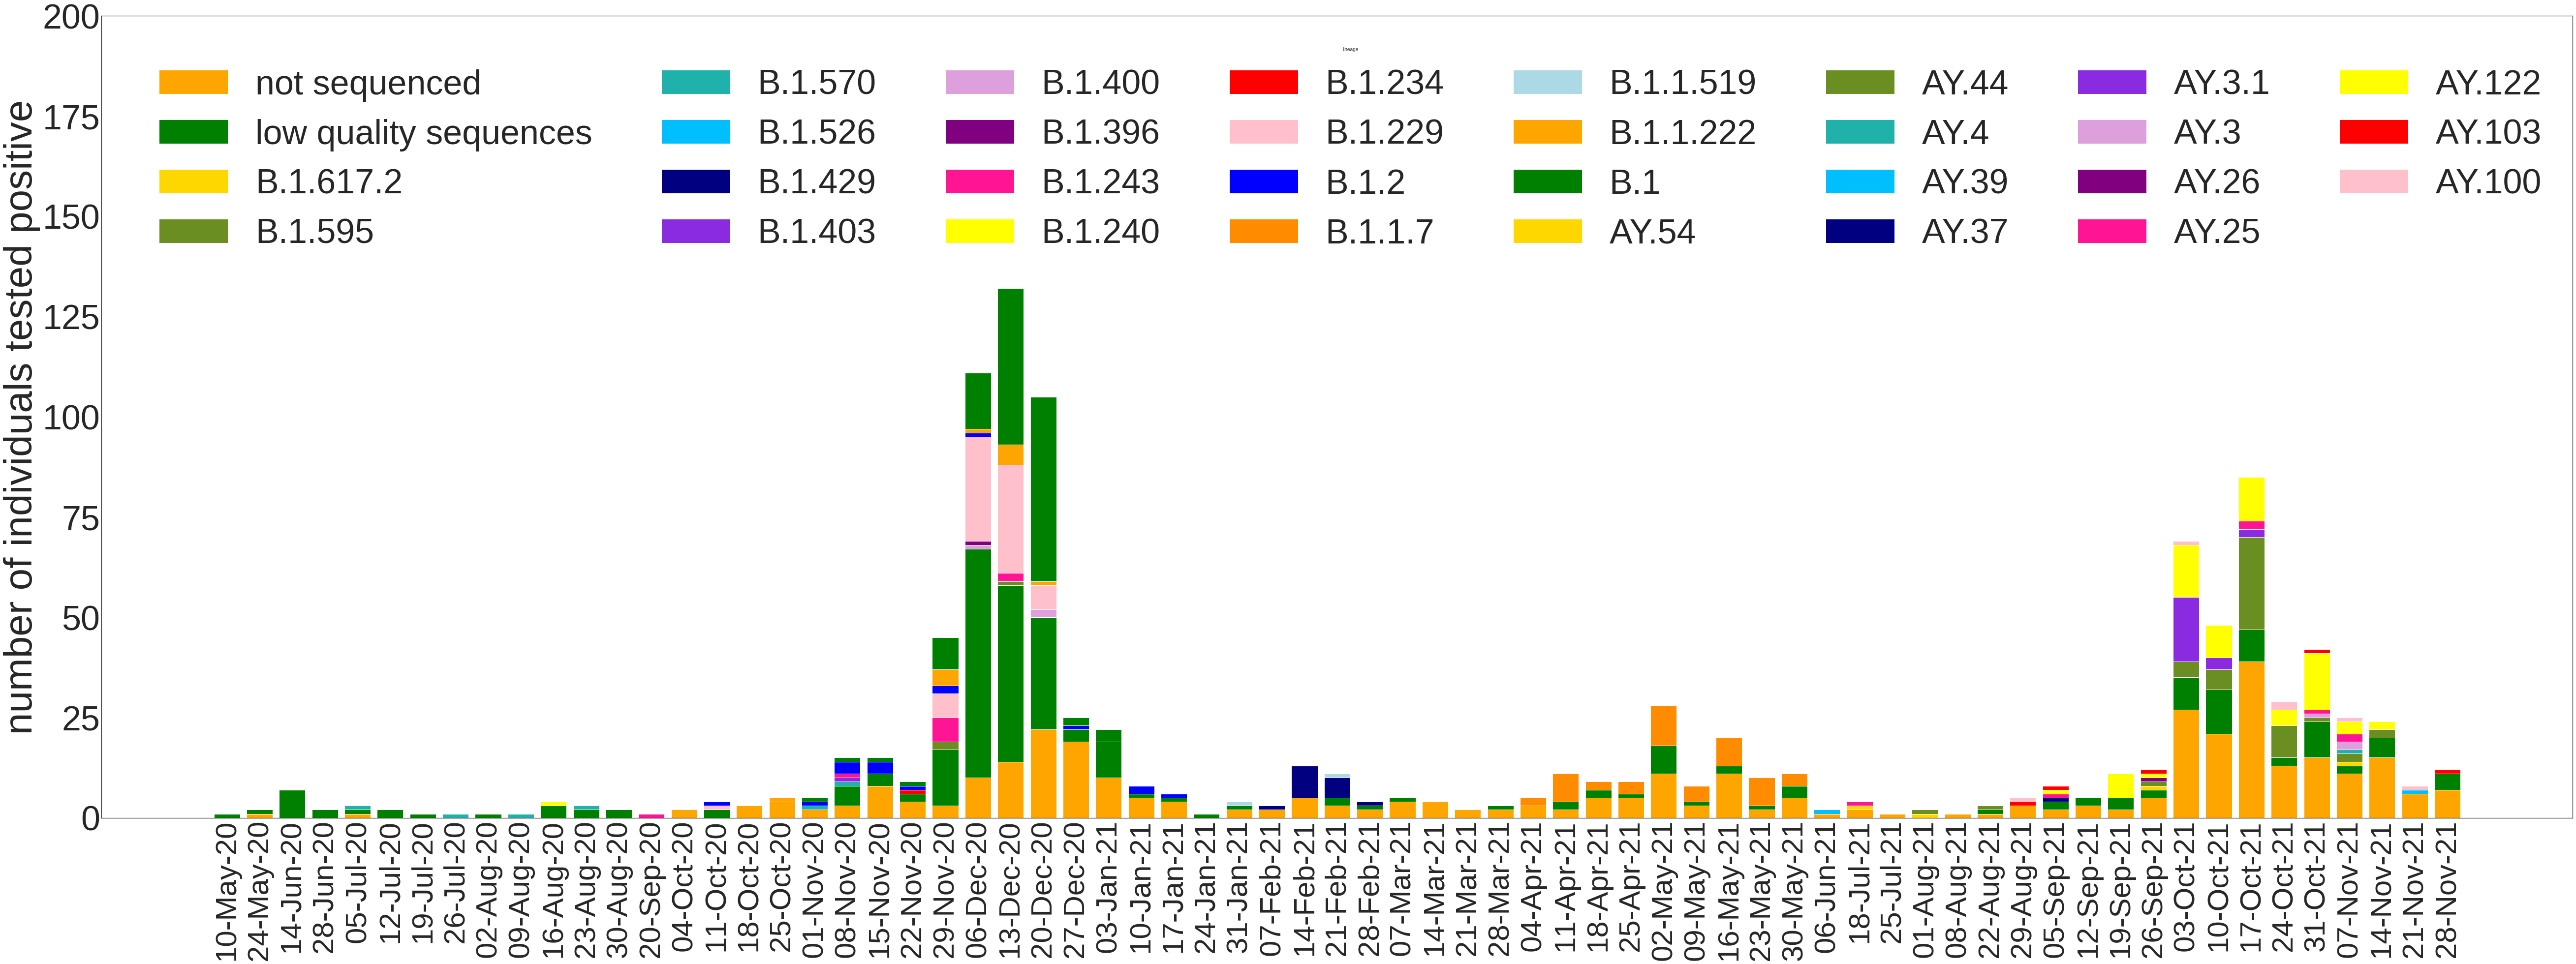

In [41]:
WC = weekly_counts.collection_date_mod.tolist()
fig, ax = plt.subplots(figsize=(90,30))
X =range(weekly_counts.shape[0])


for i in range(len(lineages)):
    print(i, lineages[i])
    if i == 0:
        #create the bar
        plt.bar(x = X, 
                height = weekly_counts[lineages[i]], 
                color = color_dict[lineages[i]], 
                edgecolor = 'white', 
                width = 0.8 )
    
    else:
        bottom_values = 0
        for k in range(i):
            if k < i :
                bottom_values = bottom_values + weekly_counts[lineages[k]]
        #create the bar
        plt.bar(x = X, 
                height = weekly_counts[lineages[i]], 
                bottom = bottom_values, 
                color = color_dict[lineages[i]], 
                edgecolor = 'white', 
                width = 0.8 )
    
    
# plt.bar(x=X, height = weekly_counts.total, width = 0.8)
plt.style.use('seaborn-white')
plt.title('')
# plt.xlabel('date', fontsize = 56)
plt.ylabel('number of individuals tested positive', fontsize = 80)
plt.ylim((0, 200))

plt.yticks(fontsize = 70)
plt.xticks(X, WC, rotation = 90, fontsize = 60)

plt.legend(color_dict.keys(), fontsize = 70, title = 'lineage', ncol=8)
# plt.legend(ncol=3)

# plt.tight_layout()
path = os.path.join(wd, 'FIGURE_epi_curve_bv_with_lineages.jpeg')
plt.savefig(path)
plt.show